# GO Cluster Analysis

In [2]:
import os
import sys
from pathlib import Path
from collections import defaultdict

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from goatools import GOEnrichmentStudy
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

from wordcloud import WordCloud

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory

# Setup notebook
nbconfig = Nb.setup_notebook()


last updated: 2018-03-15 
Git hash: b4607e6f1d22f5de926471c9887f399587814dd0


In [3]:
oboDag = GODag('../data/external/go-basic.obo')
slimDag = GODag("../data/external/goslim_generic.obo")

# Import fly associations
association = '../data/external/gene_association.fb'
fly = defaultdict(set)
with open(association) as fh:
    for row in fh.readlines():
        if row.startswith('!'):
            continue
        cols = row.split('\t')
        fbgn = cols[1]
        goterm = cols[4]
        gtype = cols[11]
        #if gtype != 'protein':
        #    continue
        if goterm not in oboDag:
            continue
        fly[fbgn].add(goterm)

# Convert from fly2go to go2fly
go2fly = defaultdict(set)
for k, v in fly.items():
    for t in v:
        if oboDag[t].namespace != 'biological_process':
            continue
            
        go2fly[t].add(k)
        

load obo file ../data/external/go-basic.obo
../data/external/go-basic.obo: fmt(1.2) rel(2018-02-02) 47,109 GO Terms
load obo file ../data/external/goslim_generic.obo
../data/external/goslim_generic.obo: fmt(1.2) rel(None) 228 GO Terms


In [4]:
# map them to a slim set
flyslim = defaultdict(set)
for fbgn, goterms in fly.items():
    all_direct_anc = set()
    all_covered_anc = set()
    all_all_anc = set()
    for goterm in goterms:
        direct_anc, all_anc = mapslim(goterm, oboDag, slimDag)
        all_all_anc |= all_anc
        # collect all covered ancestors, so the direct ancestors
        # can be calculated afterwards
        all_covered_anc |= (all_anc - direct_anc)
    all_direct_anc = all_all_anc - all_covered_anc
    flyslim[fbgn] |= (all_direct_anc)

In [7]:
res06 = pd.read_csv('../output/combined_testis_force/biomarkers_0.6.tsv', sep='\t', index_col=0)

In [8]:
res06.head()

gene_symbol          p_val  avg_logFC  pct.1  pct.2  \
primary_FBgn                                                       
FBgn0000014        abd-A  3.015707e-224   1.537089  0.792  0.112   
FBgn0000014        abd-A   0.000000e+00   1.765998  0.856  0.084   
FBgn0000015        Abd-B   0.000000e+00   2.064205  0.854  0.009   
FBgn0000017          Abl   1.509362e-69   0.612609  0.522  0.220   
FBgn0000017          Abl   7.196581e-22   0.461971  0.483  0.231   

                  p_val_adj  cluster  
primary_FBgn                          
FBgn0000014   4.316080e-220       11  
FBgn0000014    0.000000e+00        8  
FBgn0000015    0.000000e+00        8  
FBgn0000017    2.160198e-65        8  
FBgn0000017    1.029975e-17       11

In [9]:
background = res06.index.unique().tolist()

In [15]:
goObj = GOEnrichmentStudy(
    background,
    flyslim,
    slimDag,
    propagate_counts=False,
    alpha=0.001,
    methods=['fdr_bh']
)

fisher module not installed.  Falling back on scipy.stats.fisher_exact
 5,017 out of  5,743 population items found in association


In [12]:
res06_sig = res06.query('p_val_adj <= .001')

In [60]:
def go_cluster(df, clus: int, cutoff=0.001):
    _df = res06_sig.query(f'cluster == {clus}').index.unique().tolist()
    results = [res for res in goObj.run_study(_df) if res.p_fdr_bh < cutoff]

    freqs = {}
    for r in results:
        if r.name in ['biological_process', 'cellular_component', 'molecular_function']:
            continue
            
        if r.study_count > 20:
            continue 
            
        freqs[r.name] = r.study_count
        print(r.GO, r.name, r.study_count)

    wc = WordCloud(max_font_size=40).generate_from_frequencies(freqs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");
    plt.title(f'Cluster: {clus}')

Calculating uncorrected p-values using fisher_scipy_stats
   288 out of    324 study items found in association
Running multitest correction: statsmodels fdr_bh
  116 GO terms are associated with 288 of 324 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0051186 cofactor metabolic process 20
GO:0006790 sulfur compound metabolic process 13
GO:0005634 nucleus 19
GO:0005777 peroxisome 9
GO:0005615 extracellular space 16
GO:0016765 transferase activity, transferring alkyl or aryl (other than methyl) groups 13


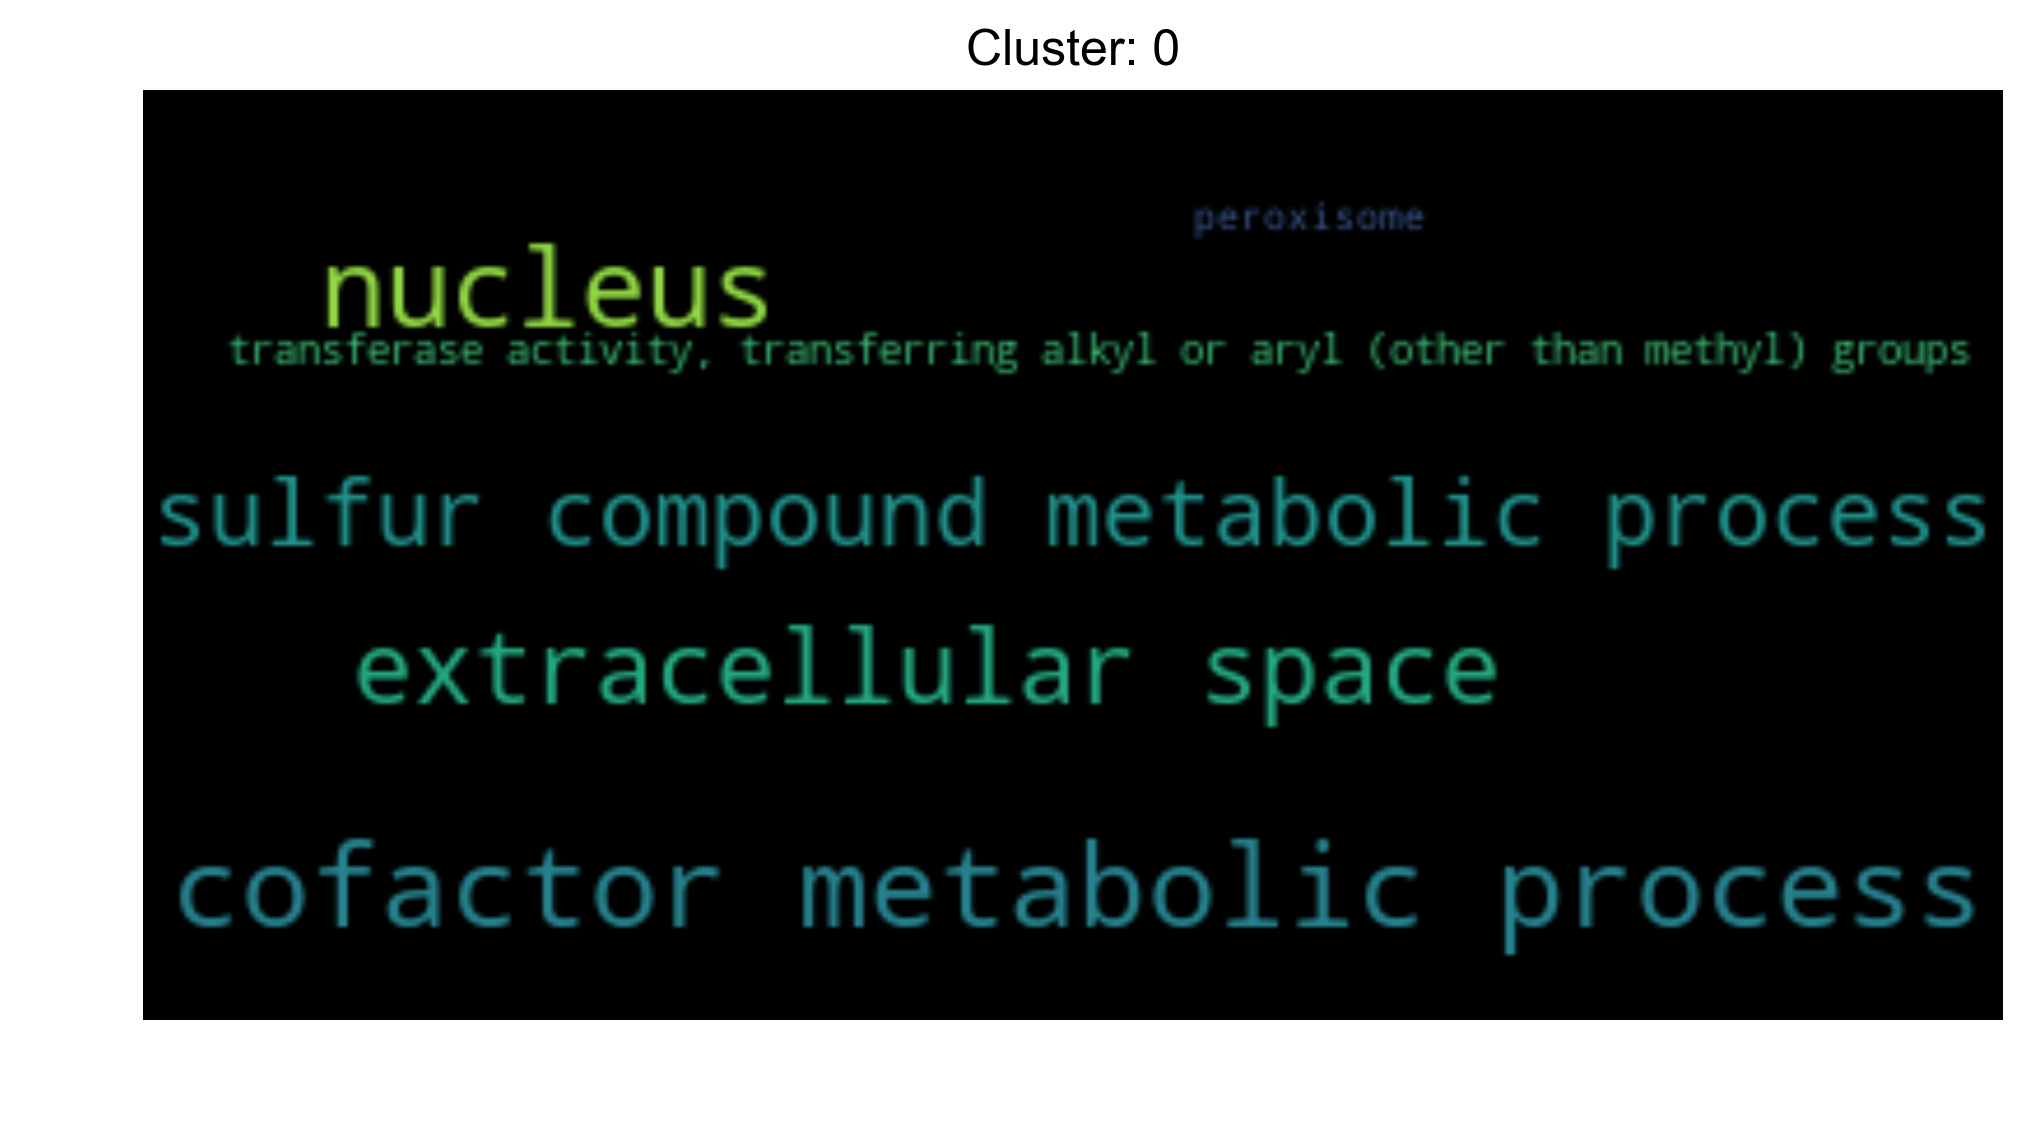

In [61]:
go_cluster(res06_sig, 0)

Calculating uncorrected p-values using fisher_scipy_stats
   476 out of    627 study items found in association
Running multitest correction: statsmodels fdr_bh
  101 GO terms are associated with 476 of 627 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0048856 anatomical structure development 16
GO:0006950 response to stress 13
GO:0007165 signal transduction 4
GO:0034641 cellular nitrogen compound metabolic process 14
GO:0009058 biosynthetic process 14
GO:0006810 transport 1
GO:0006412 translation 3
GO:0006629 lipid metabolic process 1
GO:0016192 vesicle-mediated transport 7
GO:0002376 immune system process 0
GO:0007267 cell-cell signaling 3
GO:0000278 mitotic cell cycle 1
GO:0040007 growth 1
GO:0030154 cell differentiation 1
GO:0006259 DNA metabolic process 2
GO:0005886 plasma membrane 1
GO:0005694 chromosome 0
GO:0005730 nucleolus 1
GO:0005840 ribosome 0
GO:0003677 DNA binding 5
GO:0003700 DNA binding transcription factor activity 0
GO:0003723 RNA 

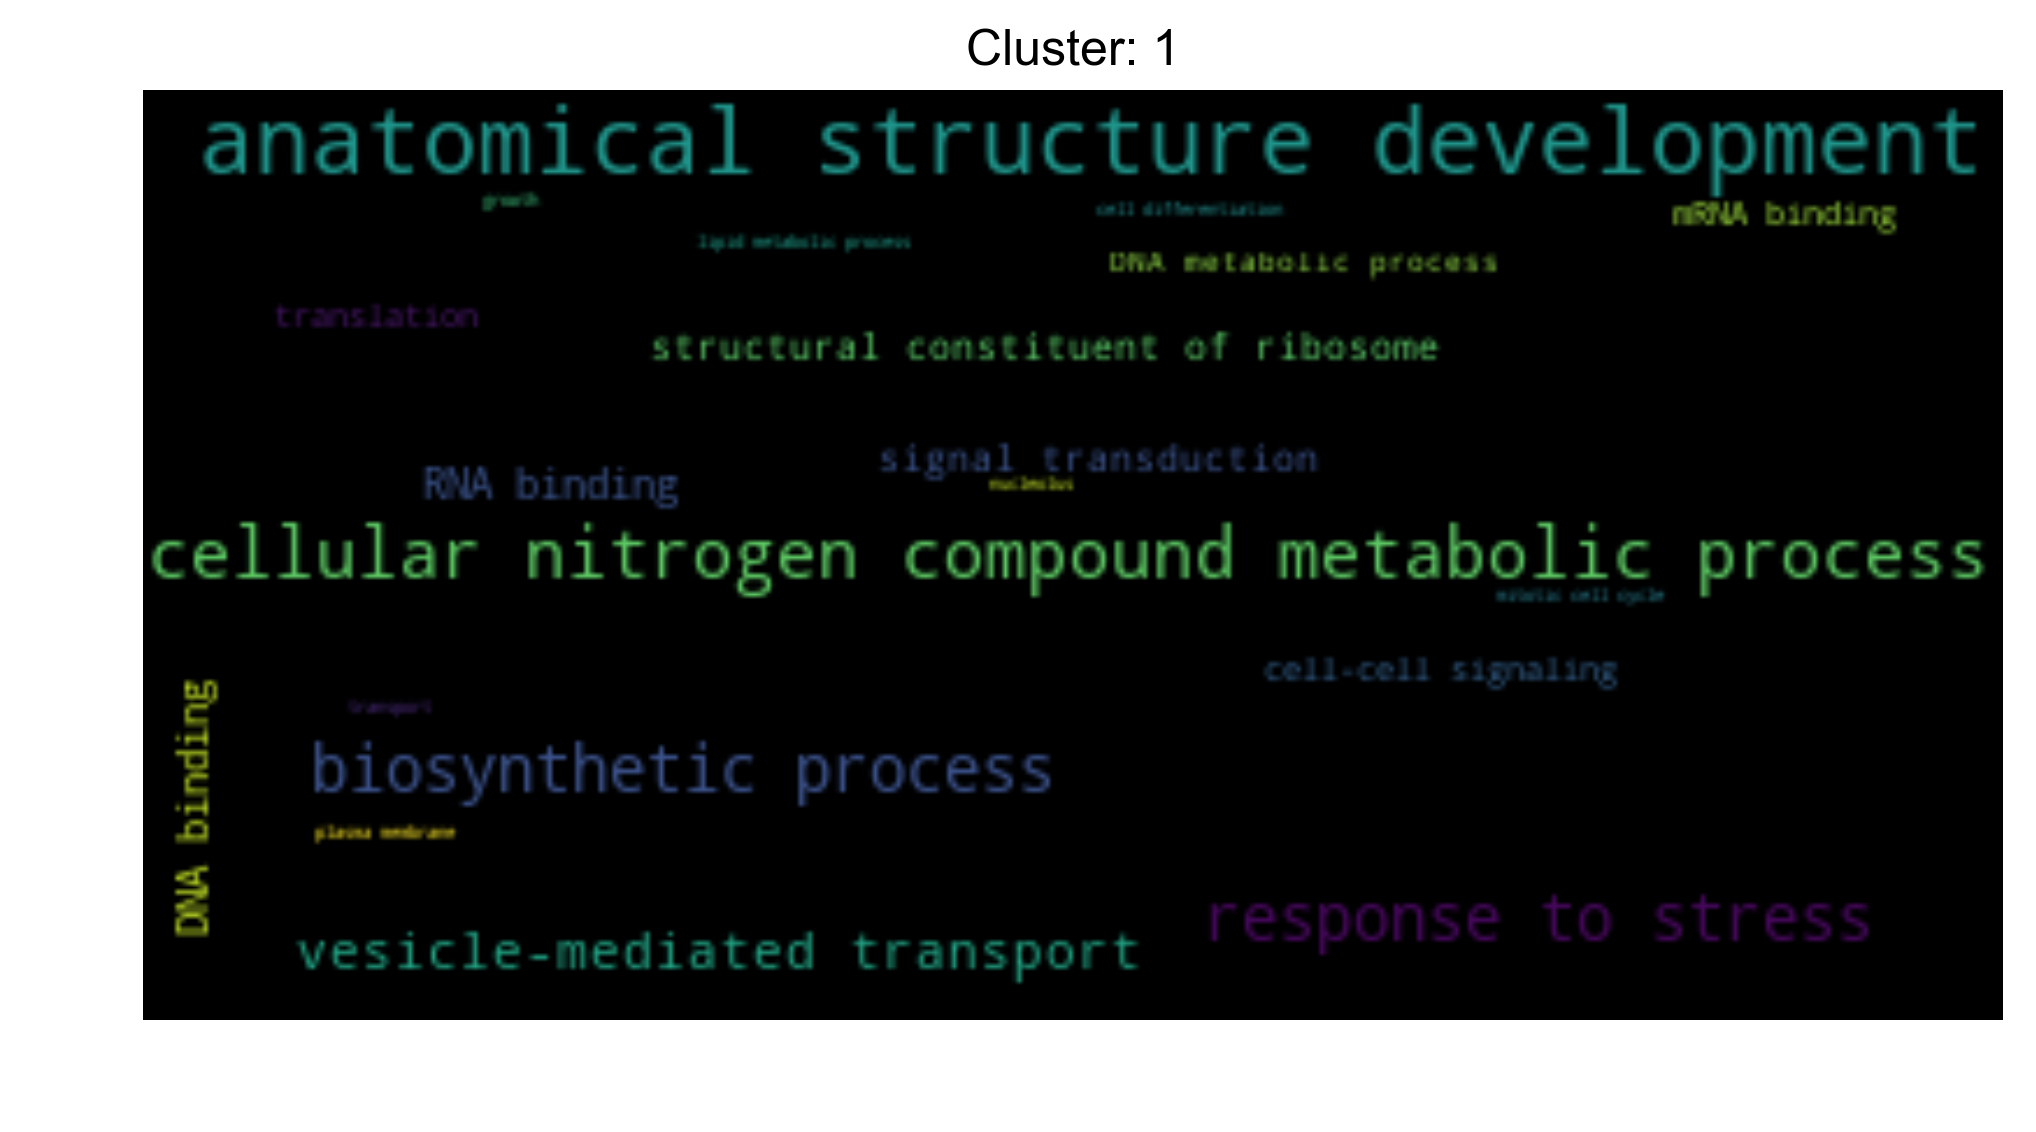

In [62]:
go_cluster(res06_sig, 1)

Calculating uncorrected p-values using fisher_scipy_stats
   323 out of    355 study items found in association
Running multitest correction: statsmodels fdr_bh
  117 GO terms are associated with 323 of 355 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0006464 cellular protein modification process 10
GO:0005975 carbohydrate metabolic process 18
GO:0006397 mRNA processing 0
GO:0005634 nucleus 14
GO:0005764 lysosome 10
GO:0016765 transferase activity, transferring alkyl or aryl (other than methyl) groups 16
GO:0003677 DNA binding 4


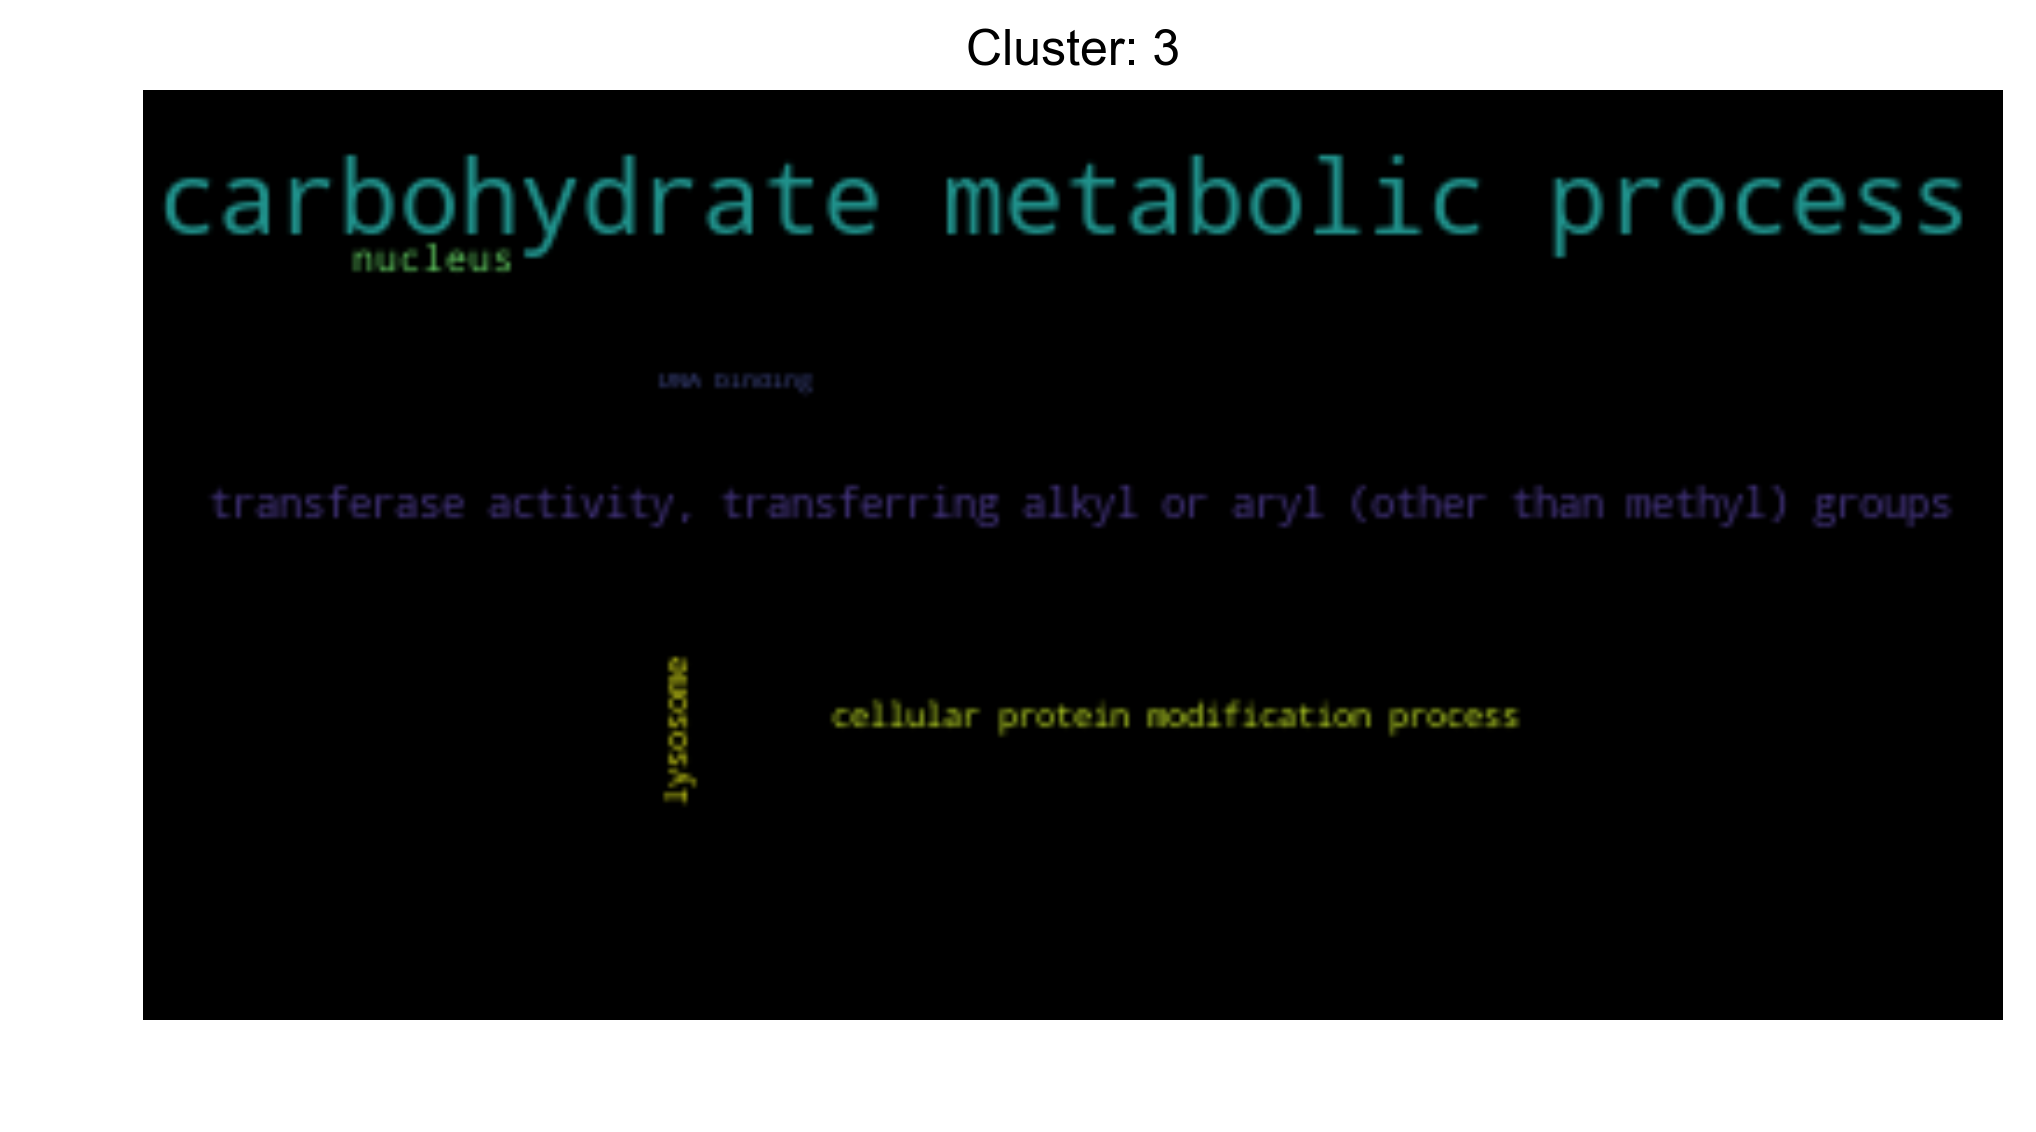

In [63]:
go_cluster(res06_sig, 3)

Calculating uncorrected p-values using fisher_scipy_stats
   499 out of    521 study items found in association
Running multitest correction: statsmodels fdr_bh
  127 GO terms are associated with 499 of 521 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0006790 sulfur compound metabolic process 17
GO:0006397 mRNA processing 2
GO:0016829 lyase activity 17
GO:0016765 transferase activity, transferring alkyl or aryl (other than methyl) groups 12


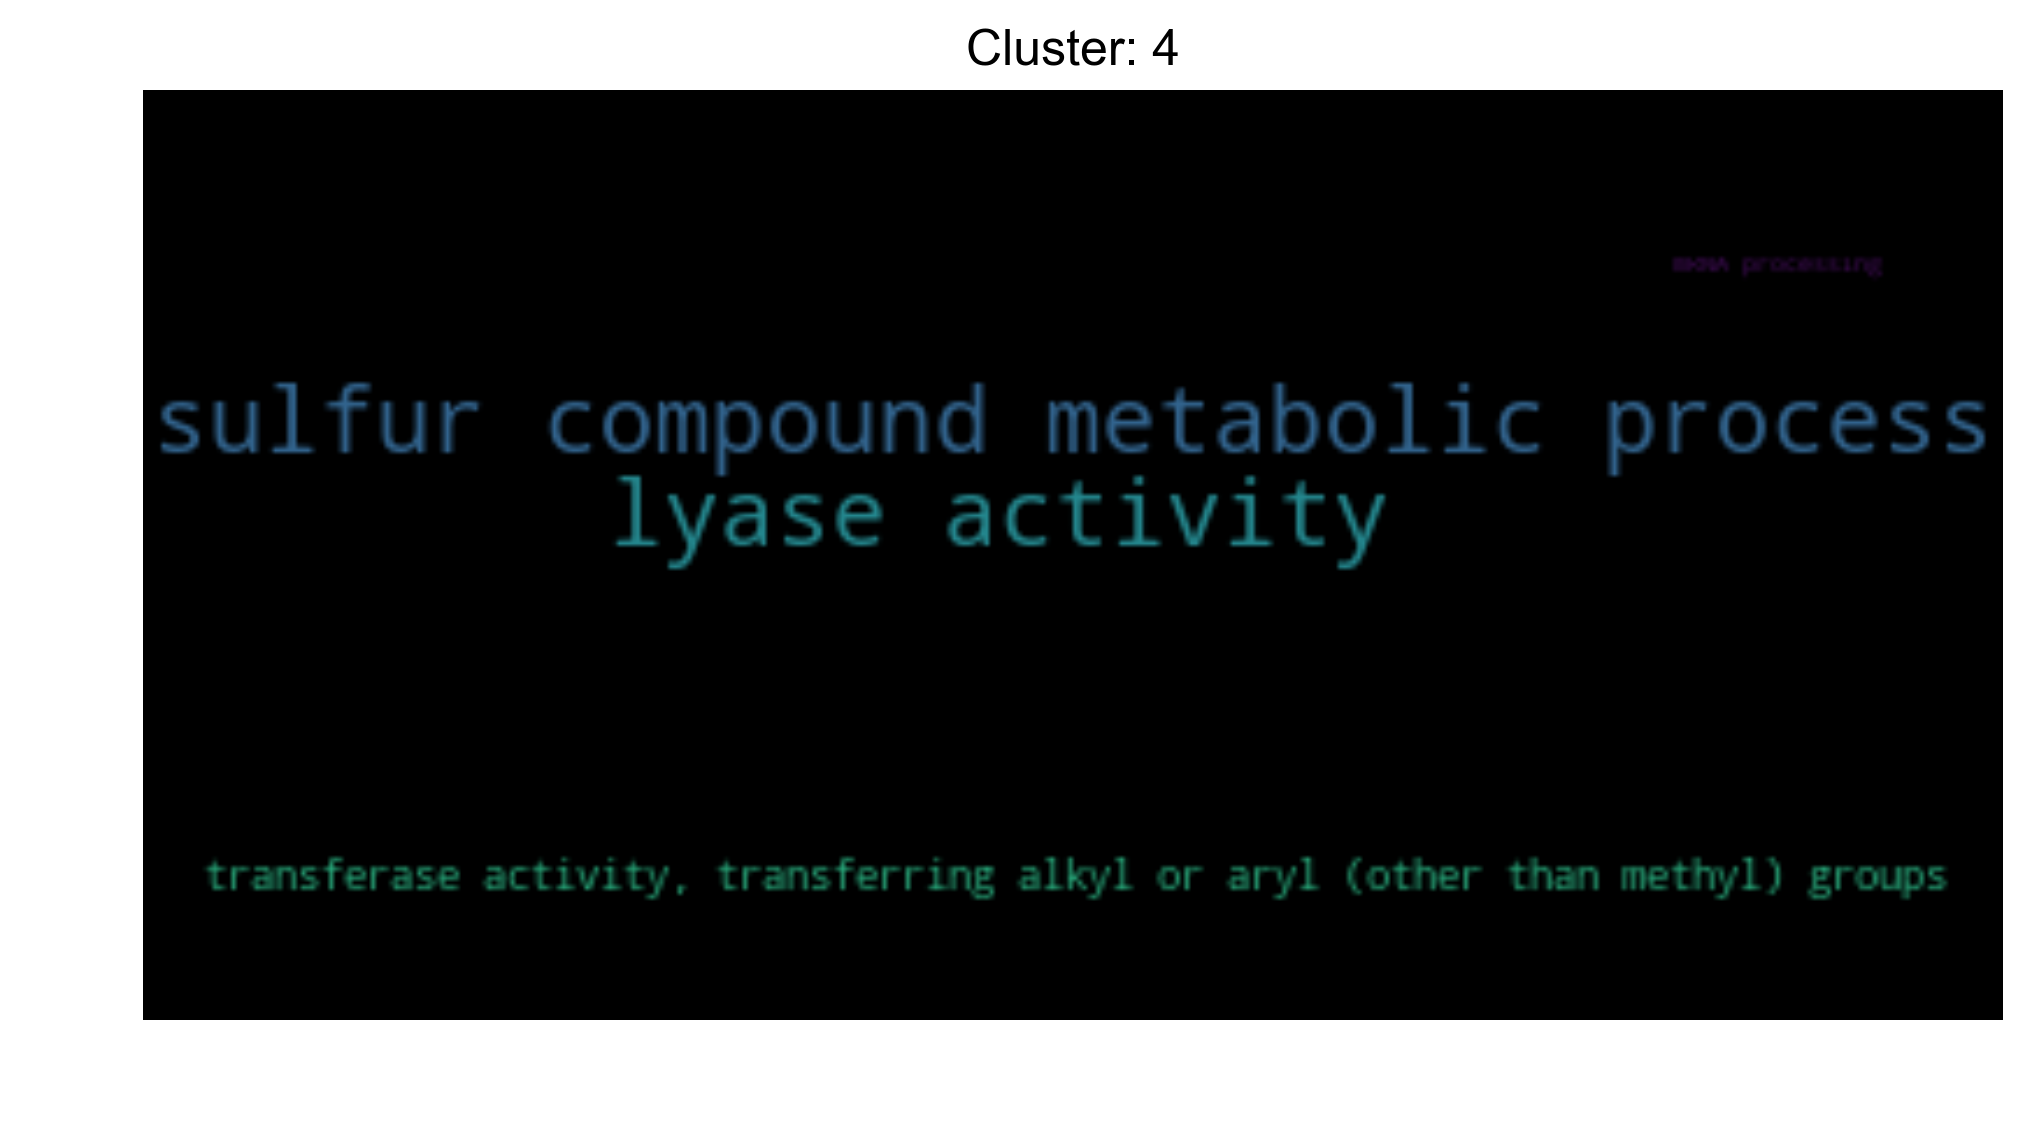

In [64]:
go_cluster(res06_sig, 4)

Calculating uncorrected p-values using fisher_scipy_stats
 1,395 out of  1,711 study items found in association
Running multitest correction: statsmodels fdr_bh
  129 GO terms are associated with 1,395 of 1,711 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0006412 translation 11
GO:0002376 immune system process 5
GO:0007155 cell adhesion 1
GO:0040007 growth 8
GO:0034330 cell junction organization 0
GO:0000902 cell morphogenesis 3
GO:0048870 cell motility 19
GO:0007267 cell-cell signaling 20
GO:0008219 cell death 9
GO:0006629 lipid metabolic process 19
GO:0008283 cell proliferation 7
GO:0030154 cell differentiation 12
GO:0006259 DNA metabolic process 17
GO:0000278 mitotic cell cycle 15
GO:0005886 plasma membrane 19
GO:0005840 ribosome 2
GO:0005654 nucleoplasm 9
GO:0005694 chromosome 12
GO:0005929 cilium 14
GO:0005730 nucleolus 17
GO:0003735 structural constituent of ribosome 7
GO:0003700 DNA binding transcription factor activity 10
GO:0004871 signal t

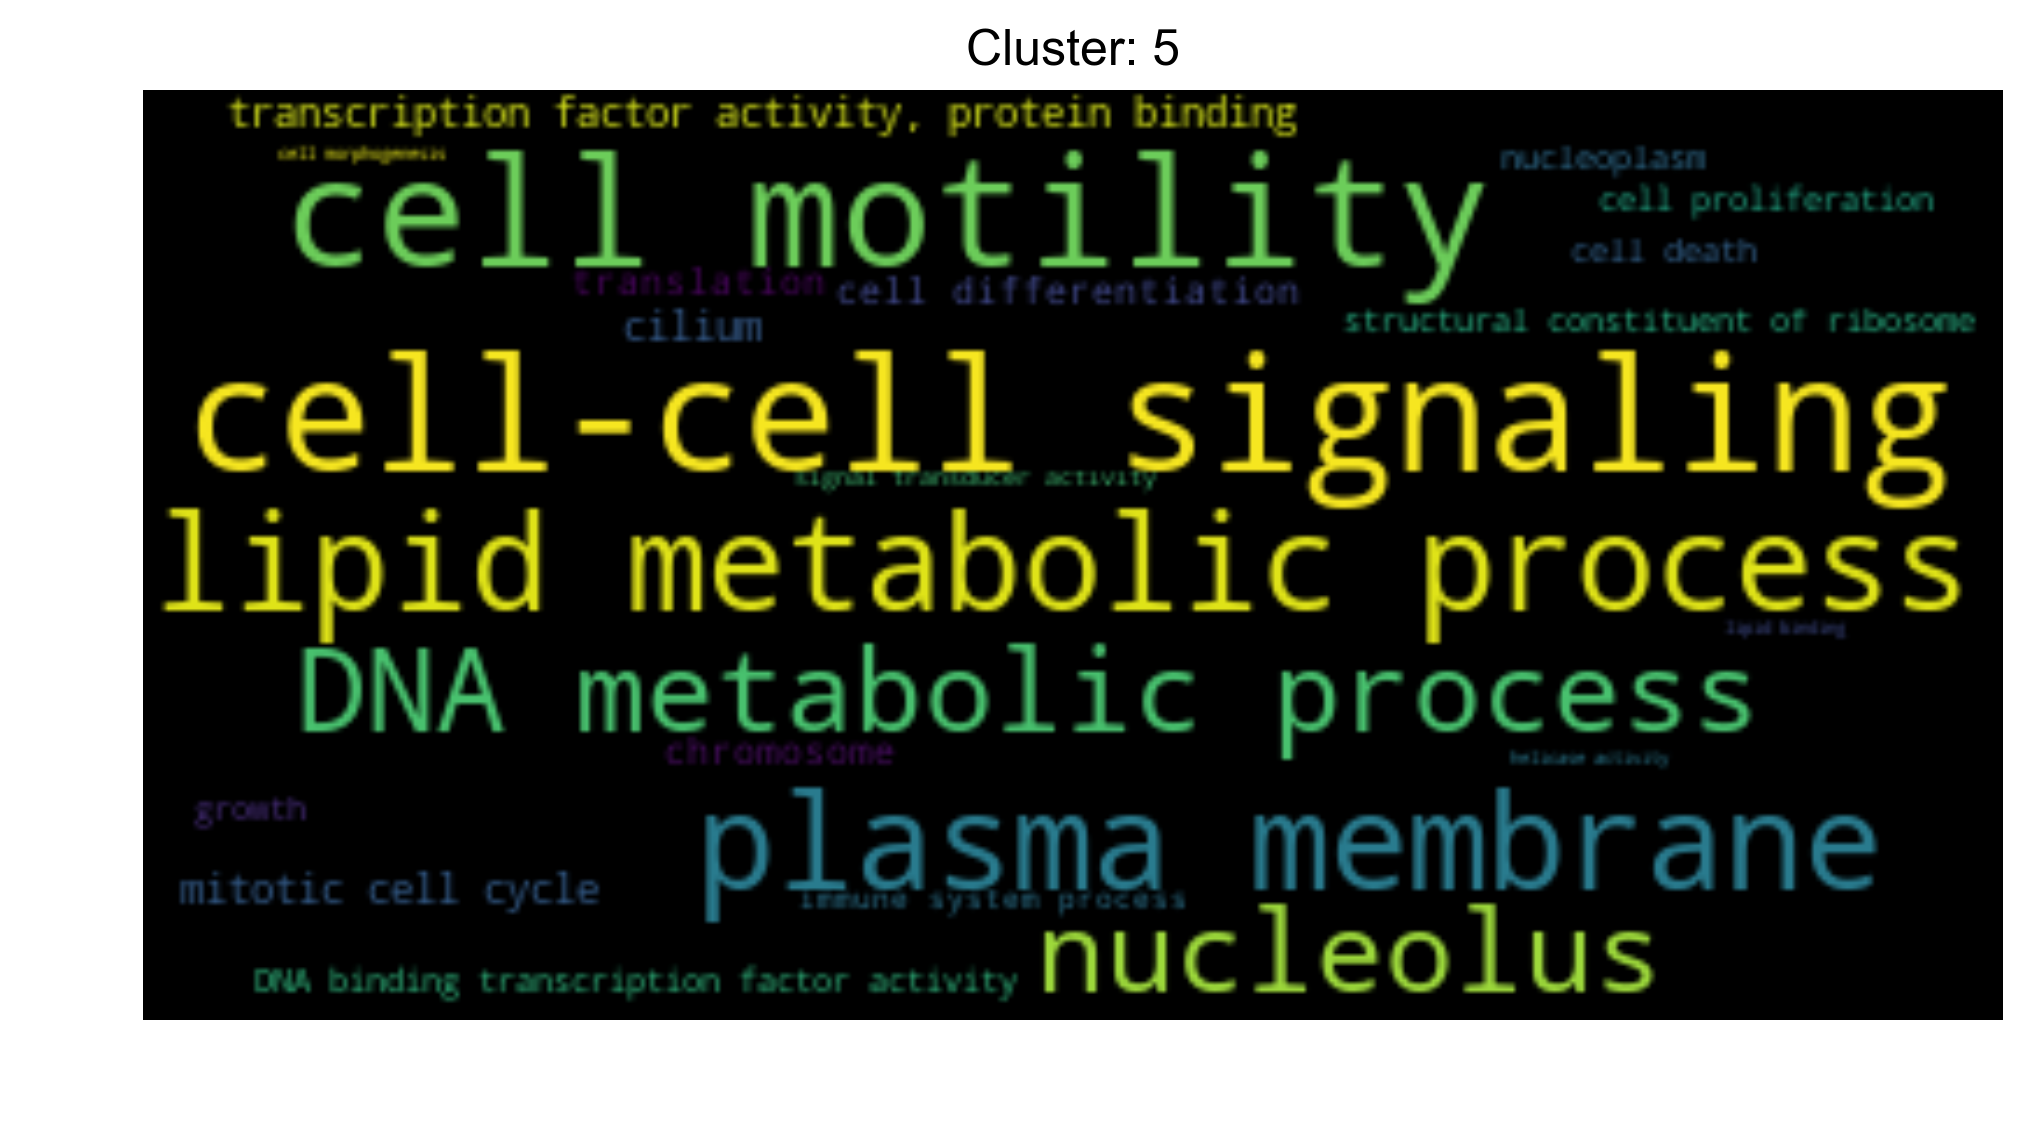

In [65]:
go_cluster(res06_sig, 5)

Calculating uncorrected p-values using fisher_scipy_stats
 1,197 out of  1,261 study items found in association
Running multitest correction: statsmodels fdr_bh
  134 GO terms are associated with 1,197 of 1,261 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0055085 transmembrane transport 13
GO:0006091 generation of precursor metabolites and energy 4
GO:0005975 carbohydrate metabolic process 3
GO:0051186 cofactor metabolic process 7
GO:0042254 ribosome biogenesis 11
GO:0065003 macromolecular complex assembly 18
GO:0005576 extracellular region 2
GO:0005635 nuclear envelope 16
GO:0022857 transmembrane transporter activity 9
GO:0019843 rRNA binding 19
GO:0042393 histone binding 18
GO:0004871 signal transducer activity 4


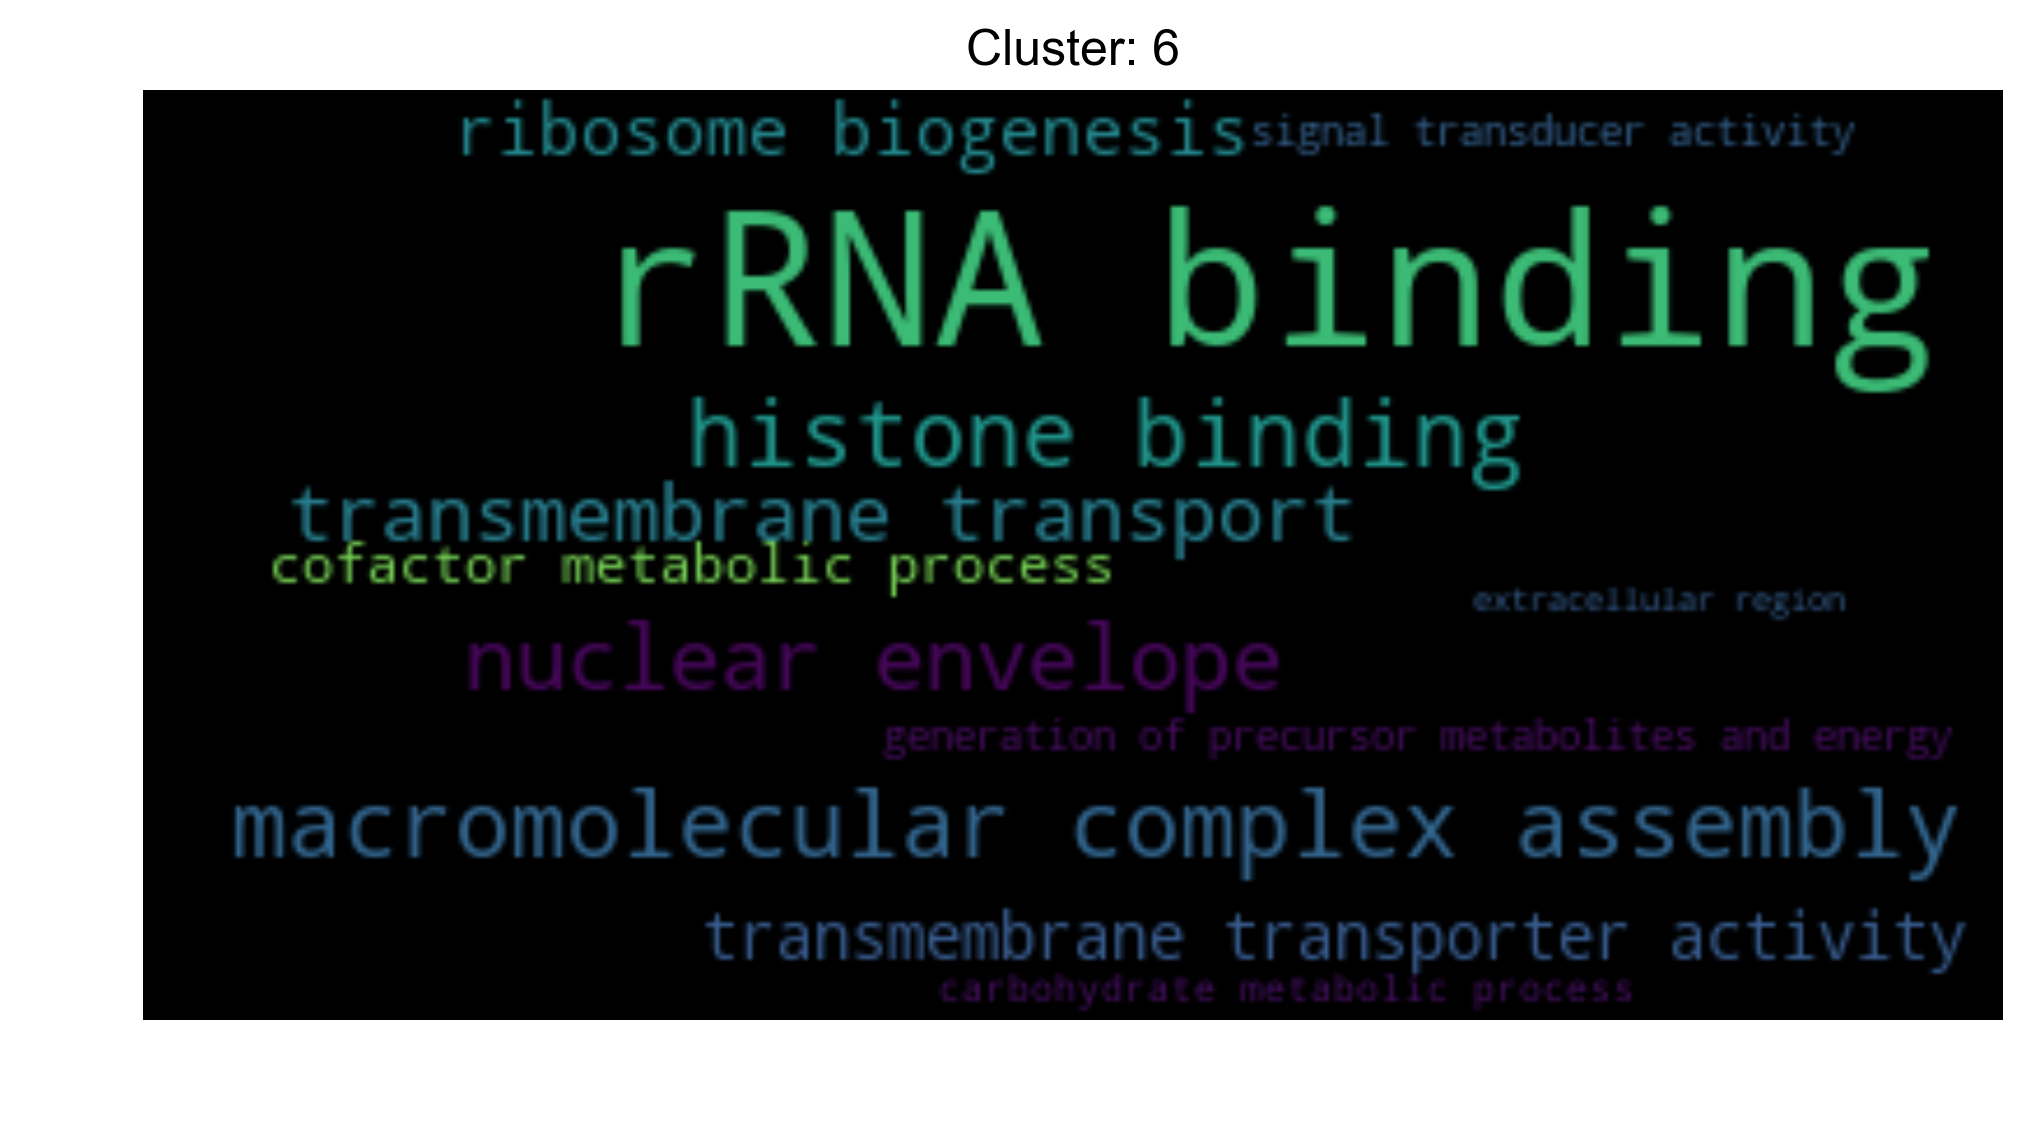

In [66]:
go_cluster(res06_sig, 6)

Calculating uncorrected p-values using fisher_scipy_stats
 1,718 out of  2,181 study items found in association
Running multitest correction: statsmodels fdr_bh
  129 GO terms are associated with 1,718 of 2,181 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0006412 translation 9
GO:0006397 mRNA processing 16
GO:0000902 cell morphogenesis 2
GO:0040007 growth 10
GO:0007155 cell adhesion 3
GO:0034330 cell junction organization 0
GO:0002376 immune system process 11
GO:0030154 cell differentiation 12
GO:0022618 ribonucleoprotein complex assembly 9
GO:0008283 cell proliferation 7
GO:0008219 cell death 12
GO:0000278 mitotic cell cycle 19
GO:0006399 tRNA metabolic process 5
GO:0040011 locomotion 7
GO:0006520 cellular amino acid metabolic process 9
GO:0051301 cell division 15
GO:0006790 sulfur compound metabolic process 9
GO:0005840 ribosome 0
GO:0005730 nucleolus 8
GO:0005694 chromosome 7
GO:0005654 nucleoplasm 10
GO:0005576 extracellular region 13
GO:0000228

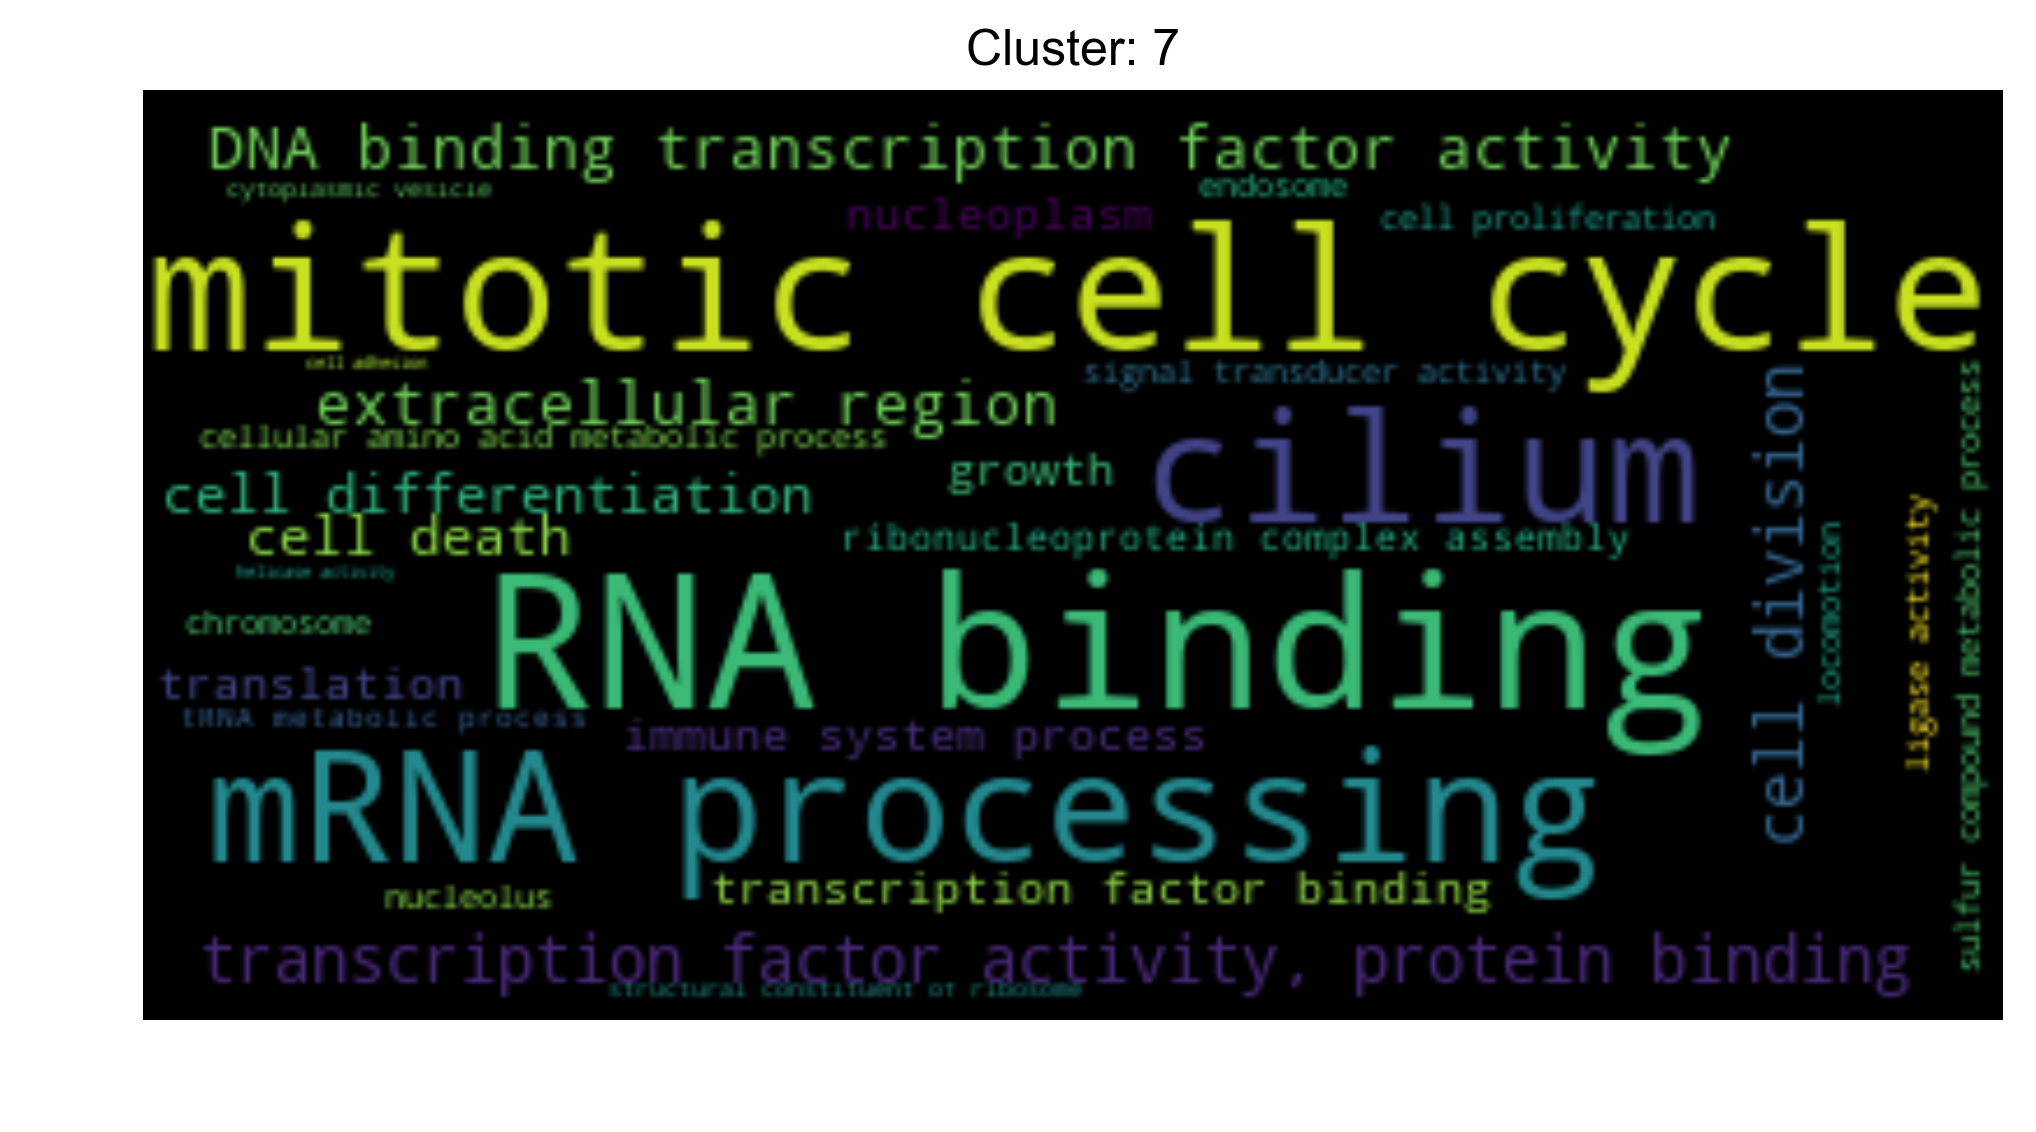

In [67]:
go_cluster(res06_sig, 7)

Calculating uncorrected p-values using fisher_scipy_stats
   657 out of    697 study items found in association
Running multitest correction: statsmodels fdr_bh
  135 GO terms are associated with 657 of 697 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0044281 small molecule metabolic process 6
GO:0009790 embryo development 18
GO:0034330 cell junction organization 18
GO:0006091 generation of precursor metabolites and energy 1
GO:0000228 nuclear chromosome 17
GO:0005739 mitochondrion 8
GO:0031410 cytoplasmic vesicle 16
GO:0005856 cytoskeleton 15
GO:0005578 proteinaceous extracellular matrix 7
GO:0016491 oxidoreductase activity 11


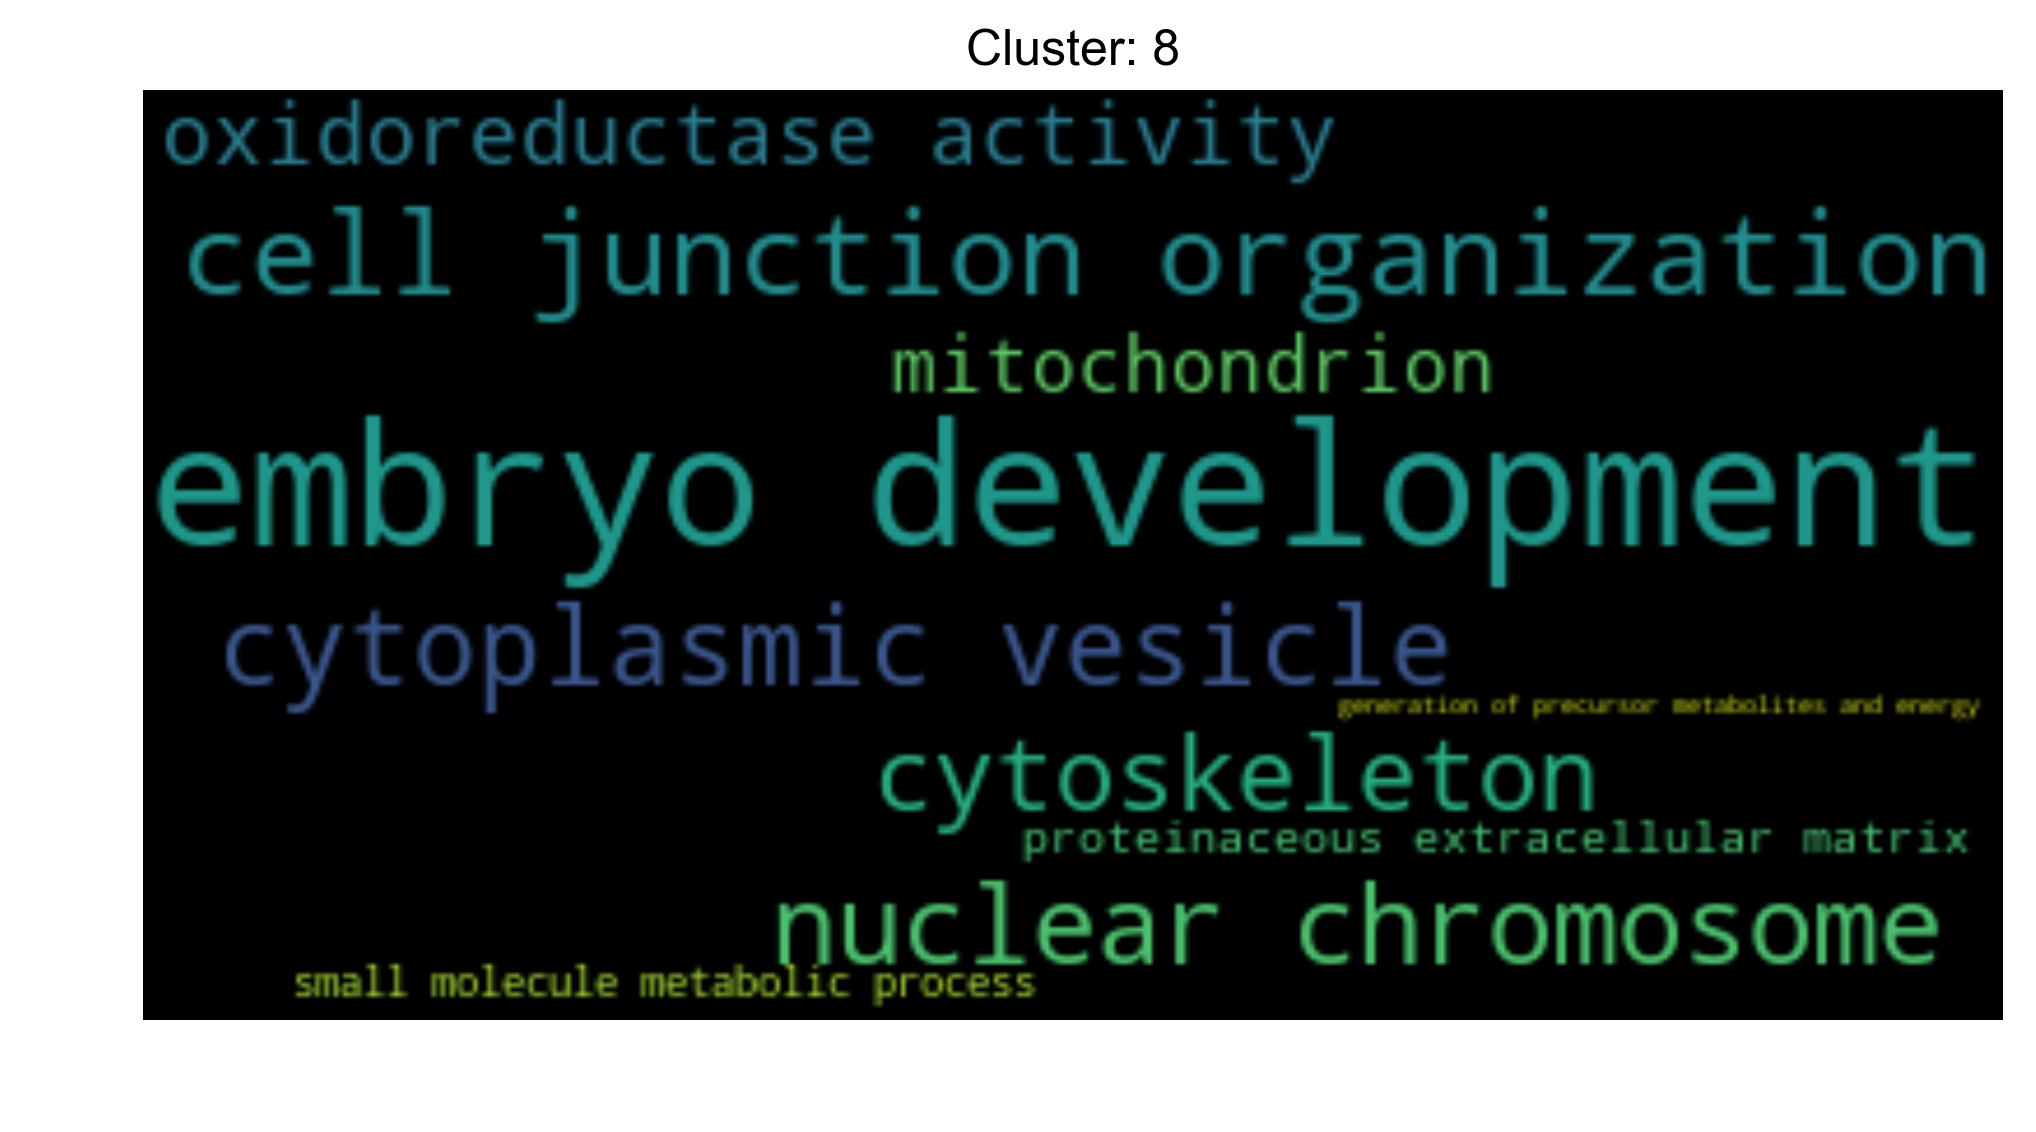

In [68]:
go_cluster(res06_sig, 8)

Calculating uncorrected p-values using fisher_scipy_stats
   513 out of    563 study items found in association
Running multitest correction: statsmodels fdr_bh
  124 GO terms are associated with 513 of 563 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0006790 sulfur compound metabolic process 20
GO:0006412 translation 2
GO:0034330 cell junction organization 14
GO:0016765 transferase activity, transferring alkyl or aryl (other than methyl) groups 14
GO:0003735 structural constituent of ribosome 1
GO:0004871 signal transducer activity 20


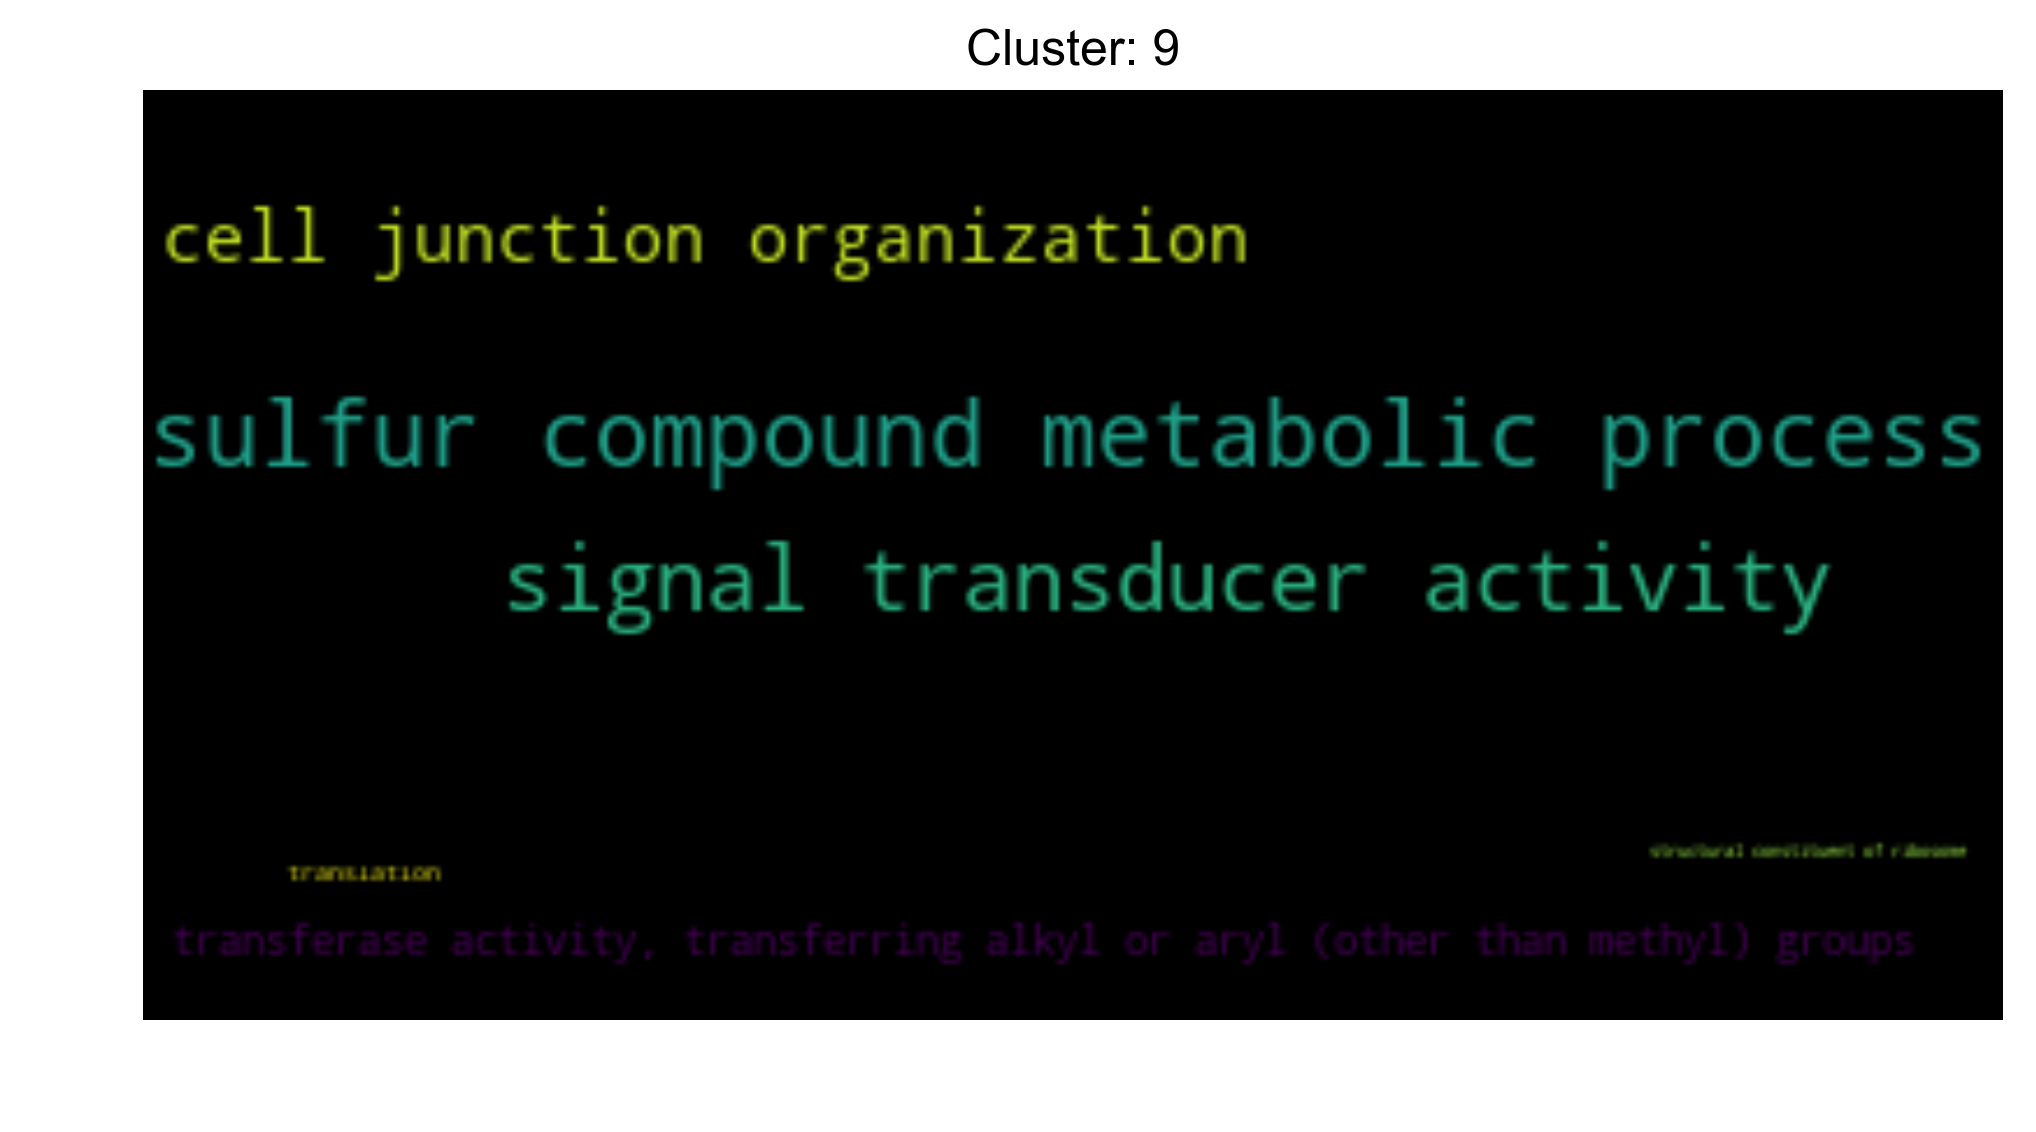

In [69]:
go_cluster(res06_sig, 9)

Calculating uncorrected p-values using fisher_scipy_stats
 1,894 out of  2,043 study items found in association
Running multitest correction: statsmodels fdr_bh
  134 GO terms are associated with 1,894 of 2,043 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0006091 generation of precursor metabolites and energy 14
GO:0007155 cell adhesion 7
GO:0034330 cell junction organization 3
GO:0005975 carbohydrate metabolic process 14
GO:0007049 cell cycle 12
GO:0005576 extracellular region 6
GO:0005615 extracellular space 11
GO:0005840 ribosome 11
GO:0005856 cytoskeleton 2
GO:0004871 signal transducer activity 7
GO:0032182 ubiquitin-like protein binding 16


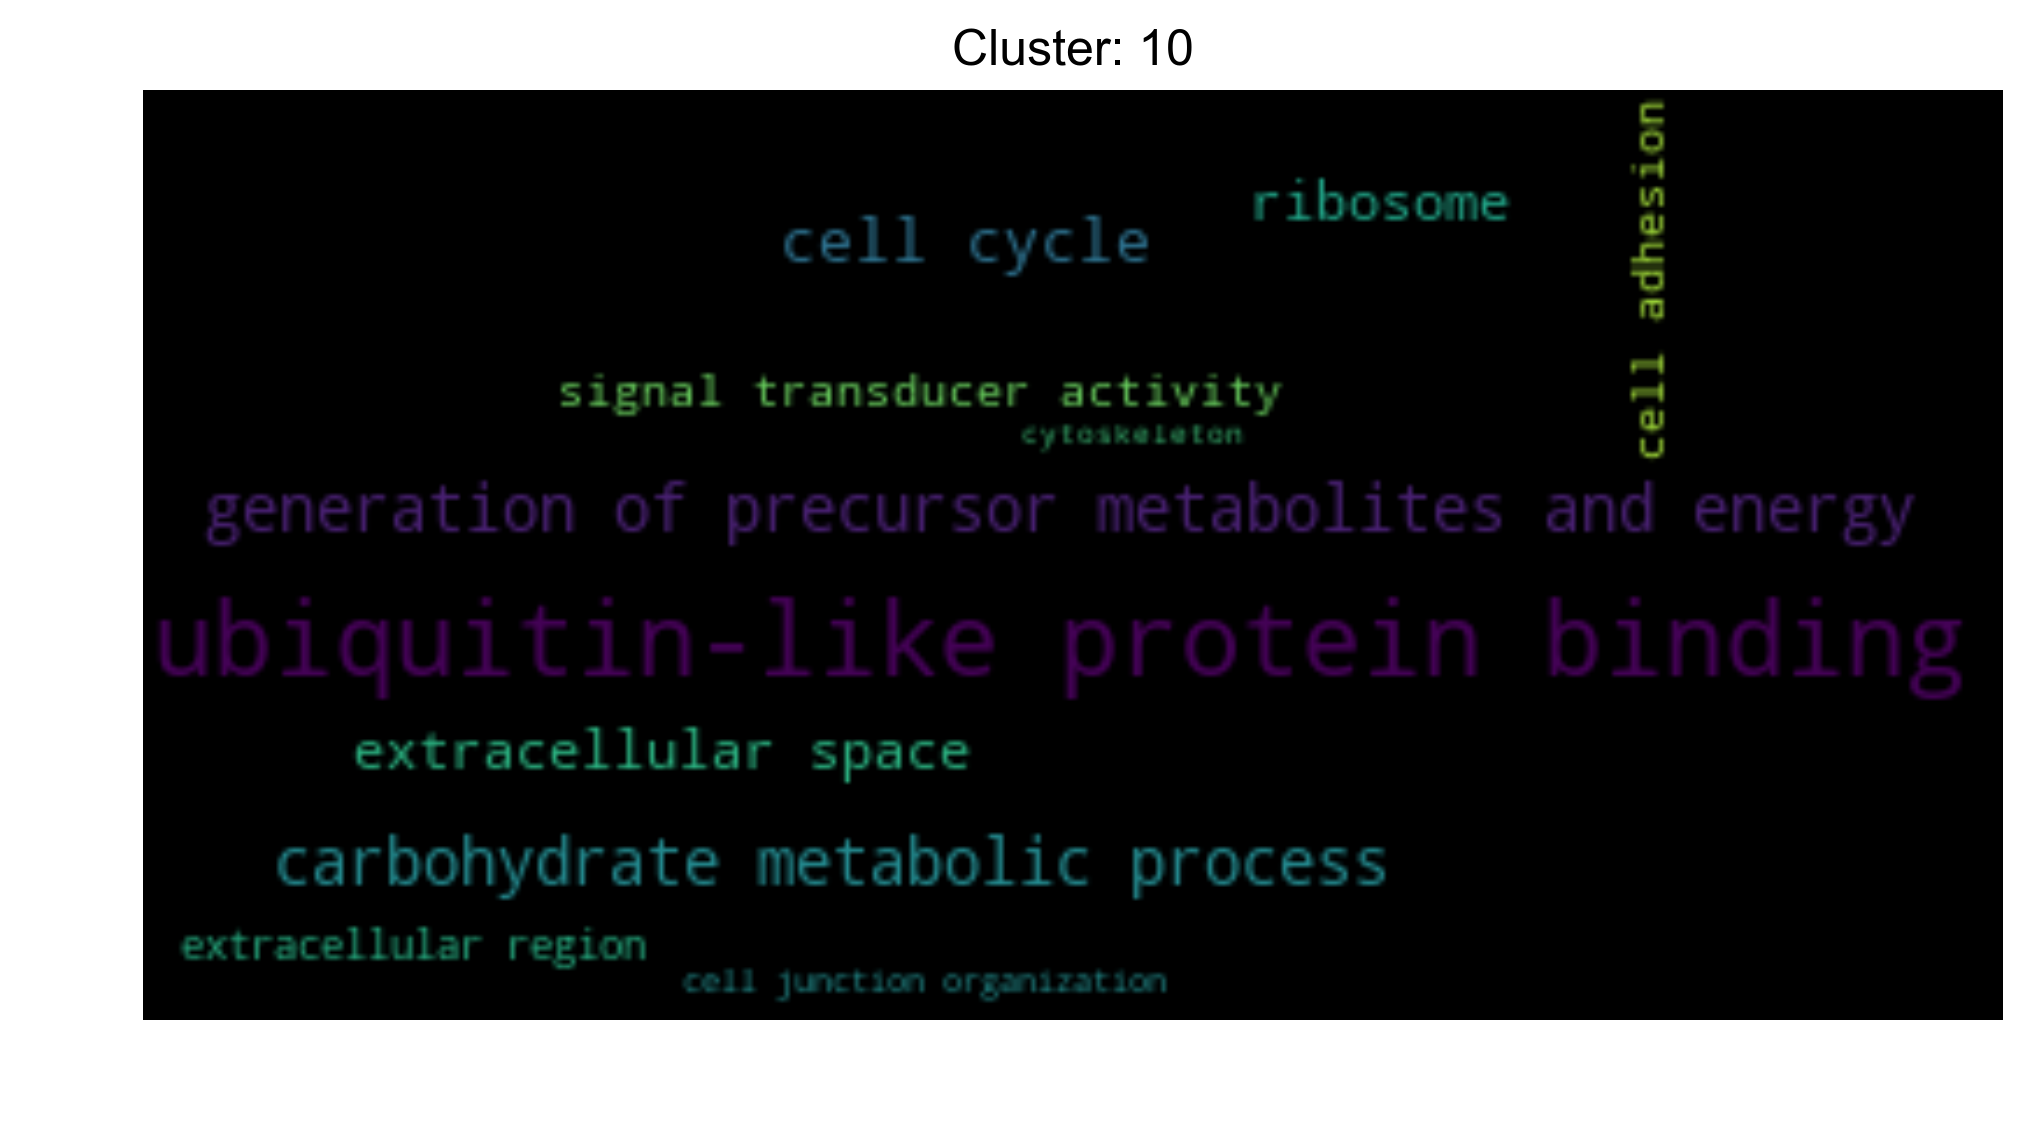

In [70]:
go_cluster(res06_sig, 10)

Calculating uncorrected p-values using fisher_scipy_stats
   754 out of    805 study items found in association
Running multitest correction: statsmodels fdr_bh
  136 GO terms are associated with 754 of 805 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0019748 secondary metabolic process 15
GO:0006091 generation of precursor metabolites and energy 1
GO:0034330 cell junction organization 19
GO:0021700 developmental maturation 16
GO:0040011 locomotion 20
GO:0005739 mitochondrion 17
GO:0008289 lipid binding 19


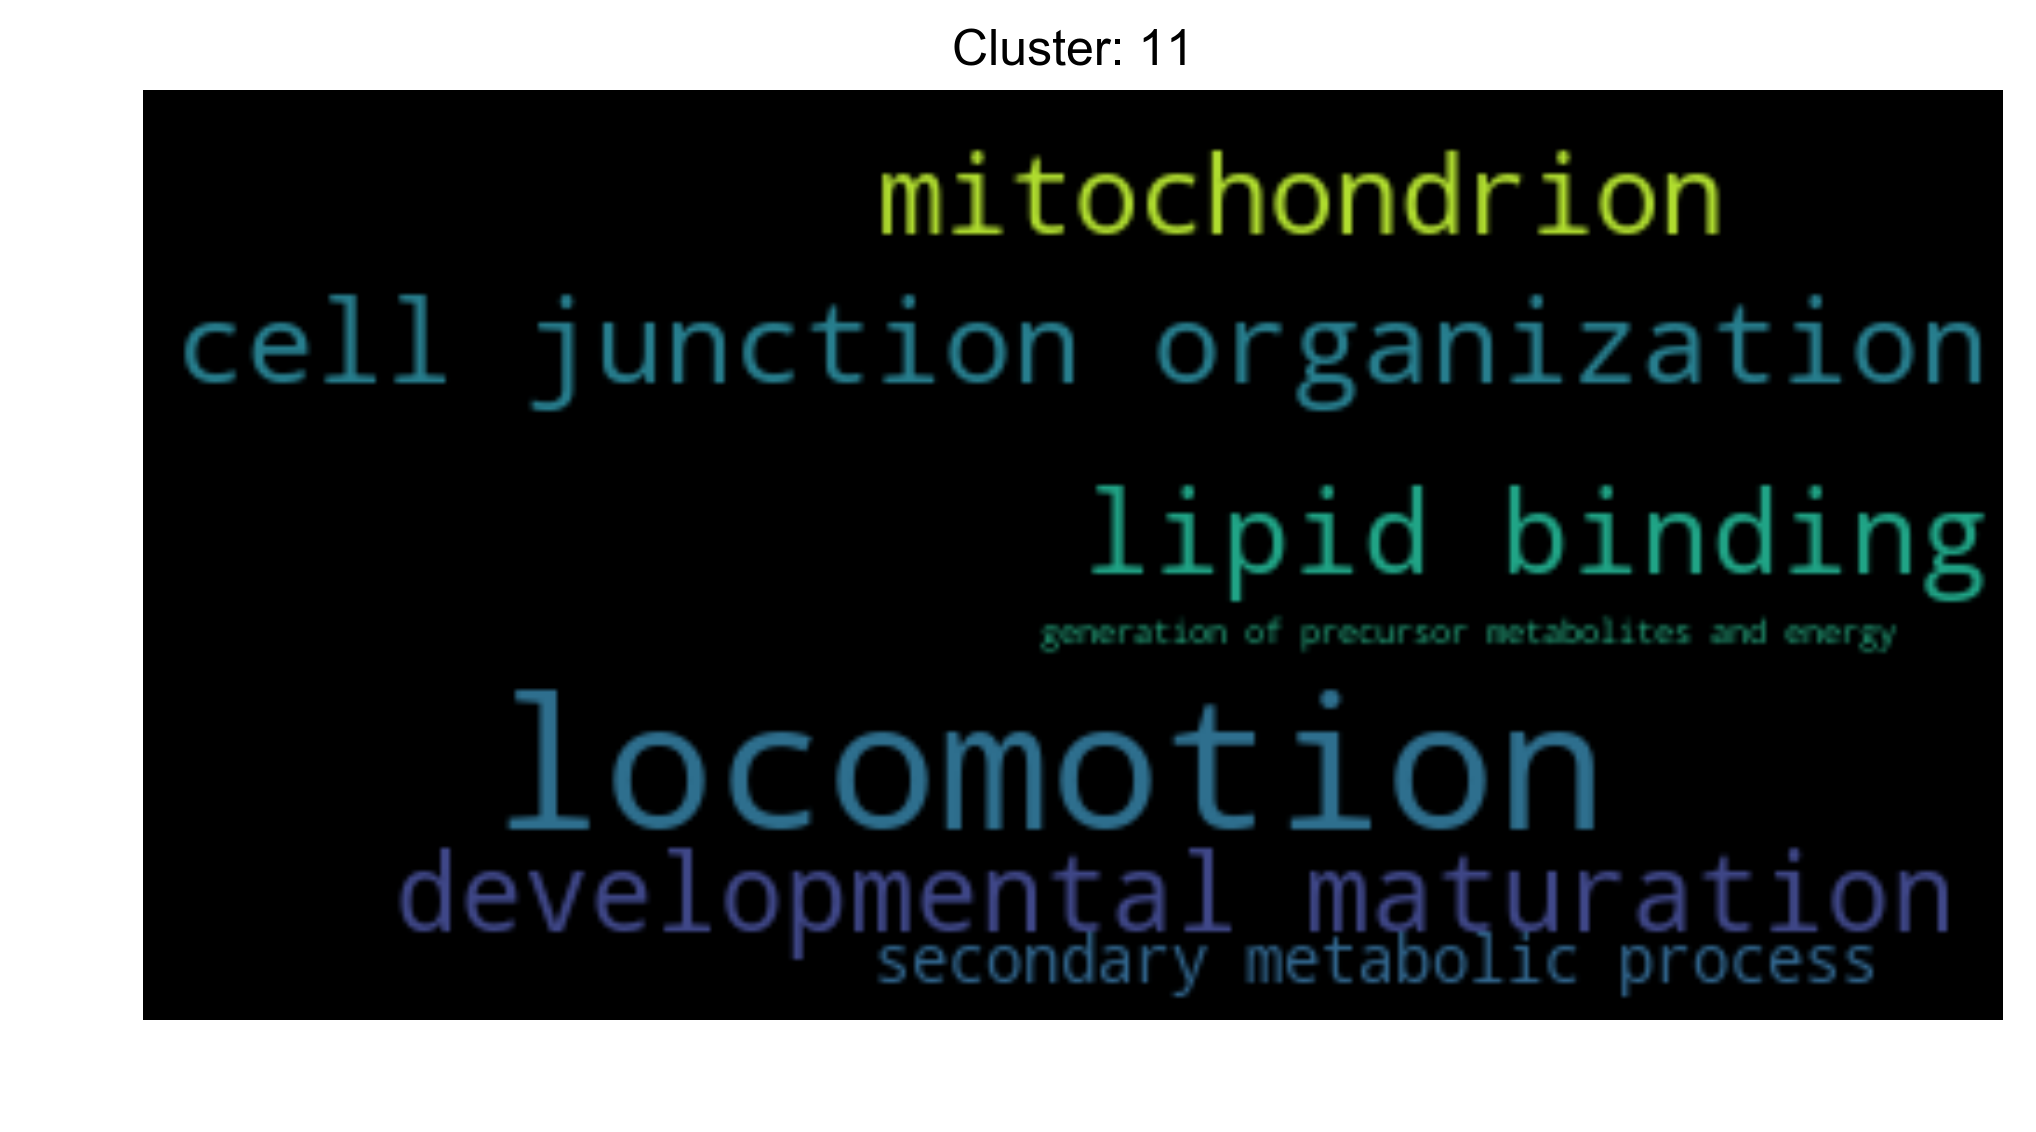

In [71]:
go_cluster(res06_sig, 11)

Calculating uncorrected p-values using fisher_scipy_stats
   584 out of    610 study items found in association
Running multitest correction: statsmodels fdr_bh
  134 GO terms are associated with 584 of 610 study items
  139 GO terms are associated with 5,017 of 5,743 population items
GO:0034330 cell junction organization 19
GO:0019843 rRNA binding 9


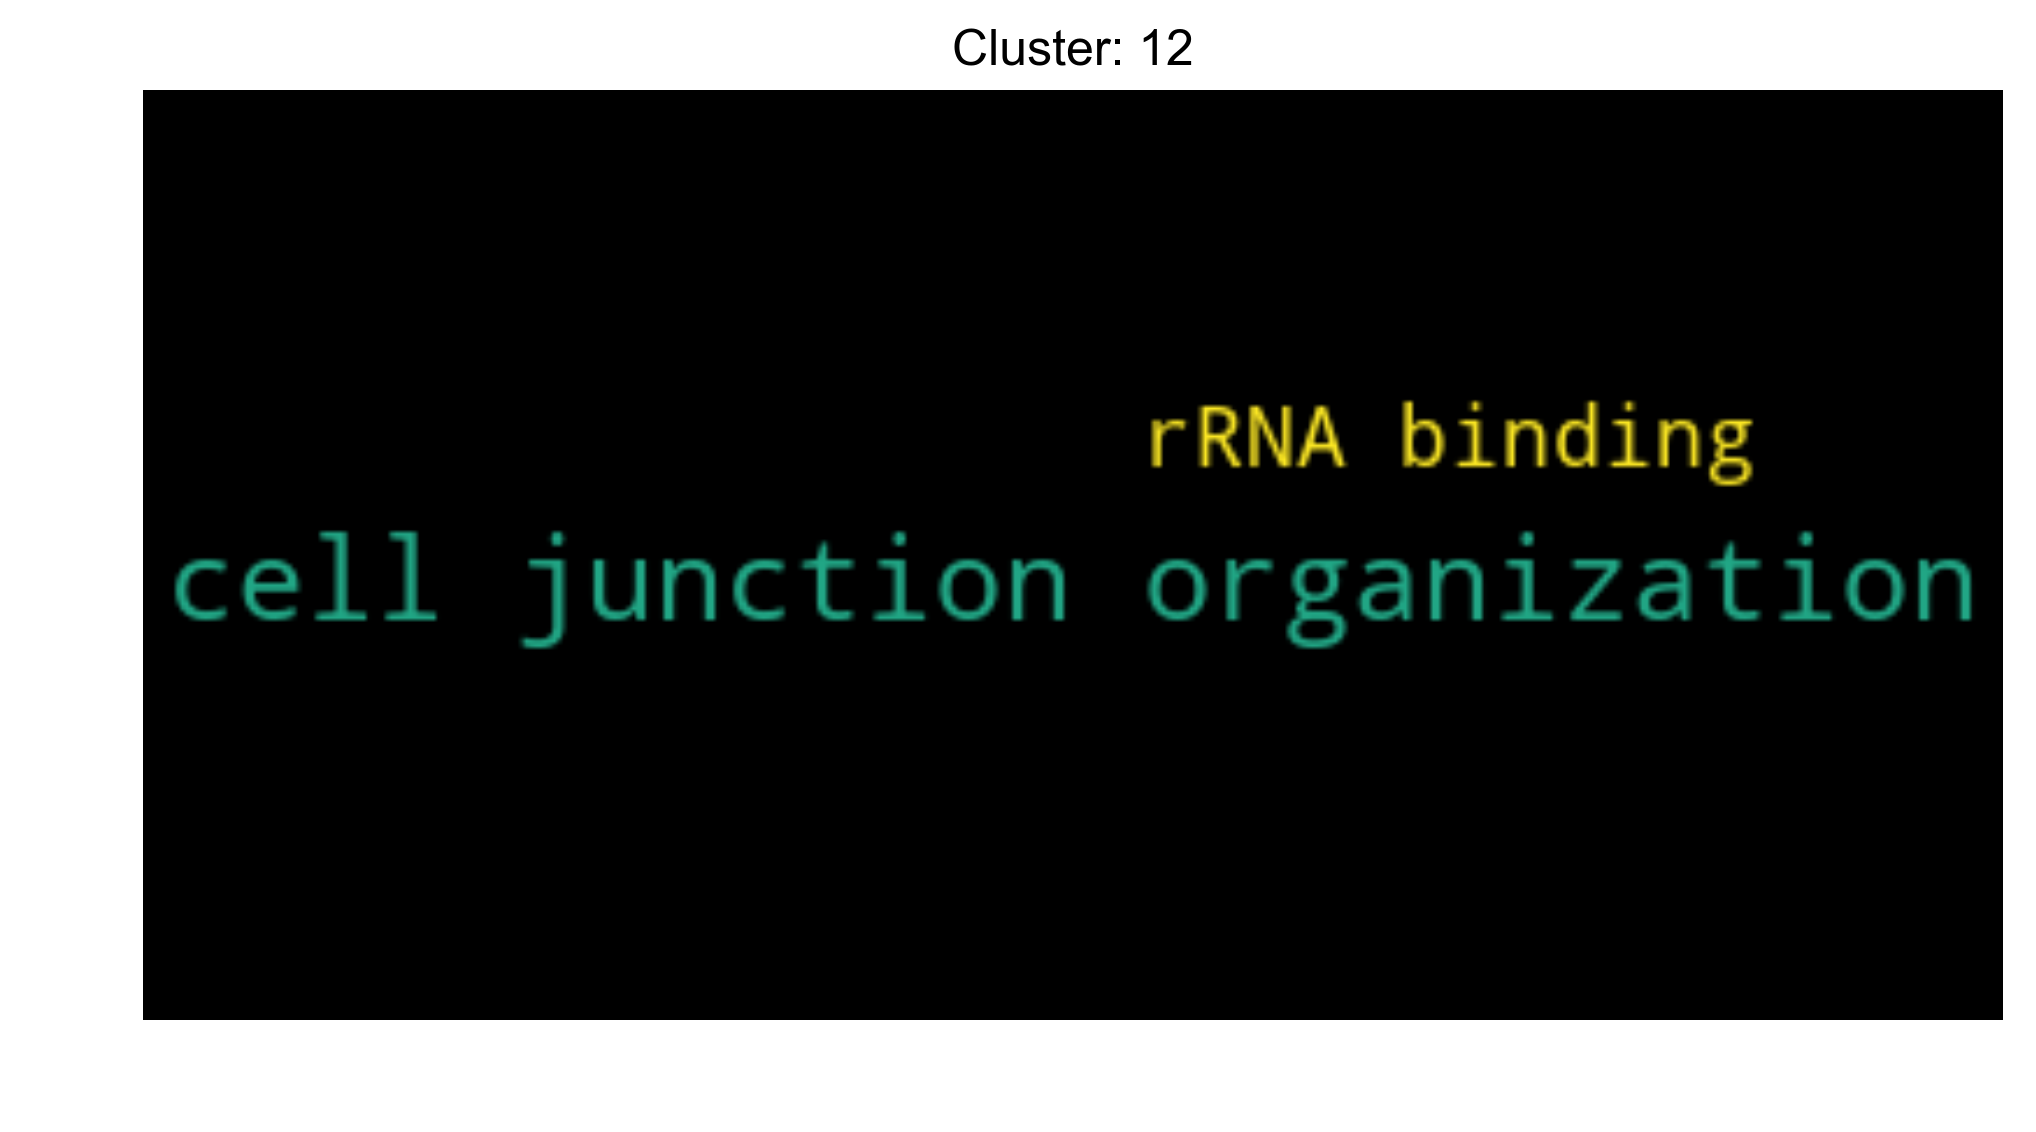

In [72]:
go_cluster(res06_sig, 12)

In [73]:
anatDag = GODag('../data/external/fly_anatomy.obo')

load obo file ../data/external/fly_anatomy.obo
../data/external/fly_anatomy.obo: fmt(1.2) rel(2017-09-06) 9,663 GO Terms


In [74]:
# Import fly associations
association = '../data/external/gene_association.fb'
fly = defaultdict(set)
with open(association) as fh:
    for row in fh.readlines():
        if row.startswith('!'):
            continue
        cols = row.split('\t')
        fbgn = cols[1]
        goterm = cols[4]
        gtype = cols[11]
        #if gtype != 'protein':
        #    continue
        if goterm not in oboDag:
            continue
        fly[fbgn].add(goterm)

{'FBbt:00000000': GOTerm('FBbt:00000000'):
   id:FBbt:00000000
   name:germ layer derivative
   namespace:
   _parents: 1 items
     FBbt:00004208
   parents: 1 items
     FBbt:00004208	level-03	depth-03	developing embryonic structure []
   children: 4 items
     FBbt:00025990	level-05	depth-05	ectodermal derivative []
     FBbt:00025994	level-05	depth-05	endodermal derivative []
     FBbt:00025997	level-05	depth-05	mesectodermal derivative []
     FBbt:00025998	level-05	depth-05	mesodermal derivative []
   level:4
   depth:4
   is_obsolete:False
   alt_ids: 0 items, 'FBbt:00000001': GOTerm('FBbt:00000001'):
   id:FBbt:00000001
   name:organism
   namespace:
   _parents: 1 items
     FBbt:00100313
   parents: 1 items
     FBbt:00100313	level-03	depth-03	multicellular structure []
   children: 9 items
     FBbt:00000034	level-05	depth-05	egg []
     FBbt:00000052	level-05	depth-05	embryo []
     FBbt:00001727	level-05	depth-05	larva []
     FBbt:00002952	level-05	depth-05	prepupa []
   